In [34]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Input, Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics



In [2]:
df = pd.read_csv('data/AAPL.csv', index_col='Date', parse_dates=True)

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367031,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800
...,...,...,...,...,...,...
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3.583000e+03
mean,61.958994,62.617478,61.326966,62.001624,59.955541,2.392140e+08
std,57.141881,57.767183,56.560324,57.196397,57.588650,2.198279e+08
min,6.870357,7.000000,6.794643,6.858929,5.806765,2.404830e+07
25%,19.911428,20.108929,19.720357,19.898750,17.168917,9.039615e+07
50%,33.615002,33.772499,33.312500,33.755001,31.510021,1.491976e+08
75%,113.980000,115.490002,112.235001,113.669998,111.288128,3.226342e+08
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.880998e+09


In [4]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

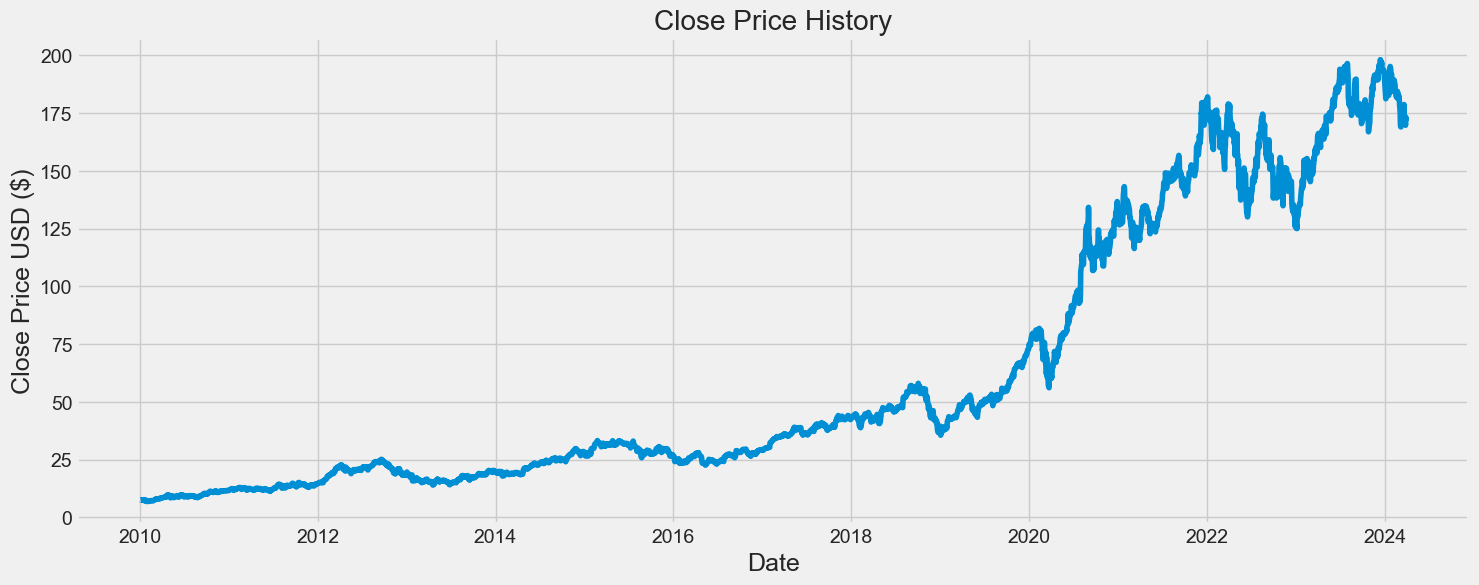

In [5]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

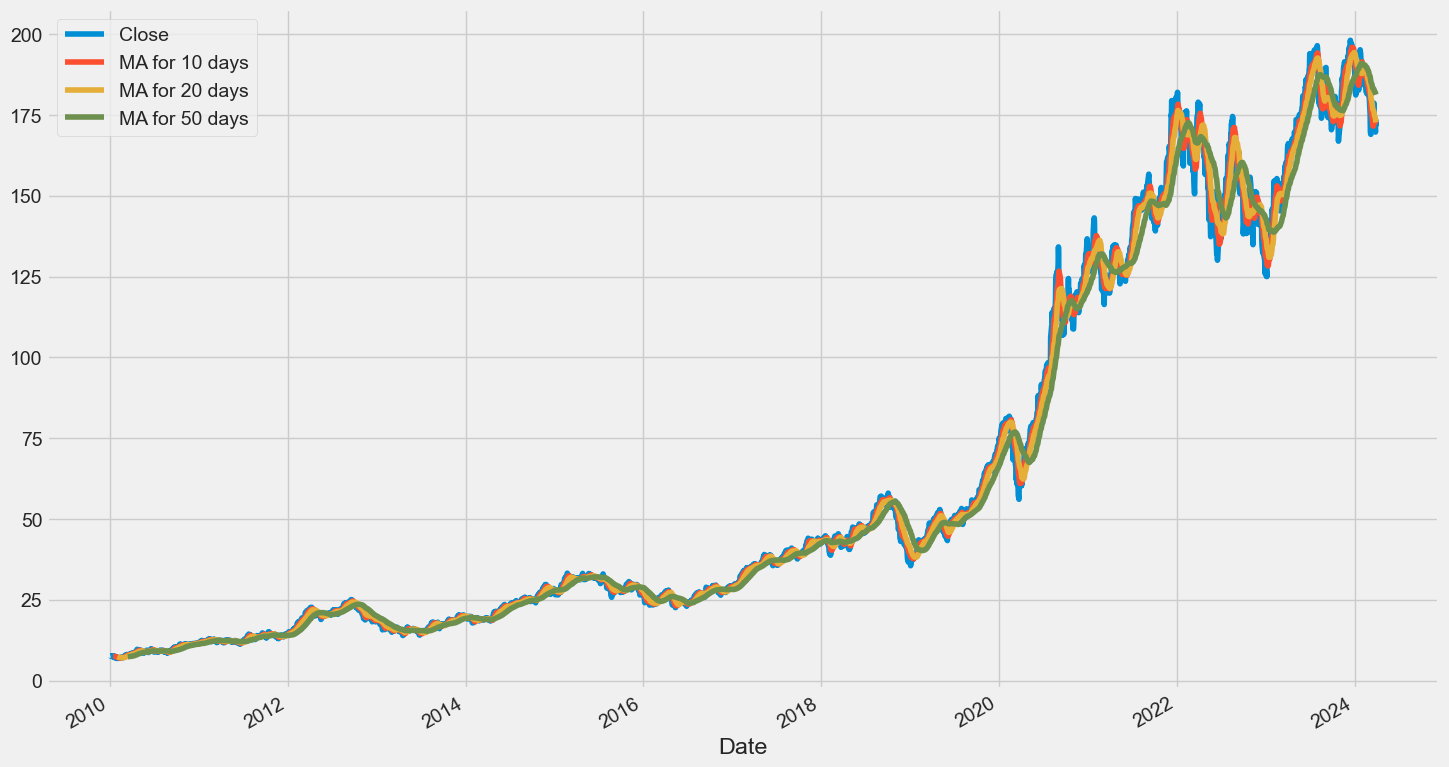

In [6]:
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(16,10))
plt.show()

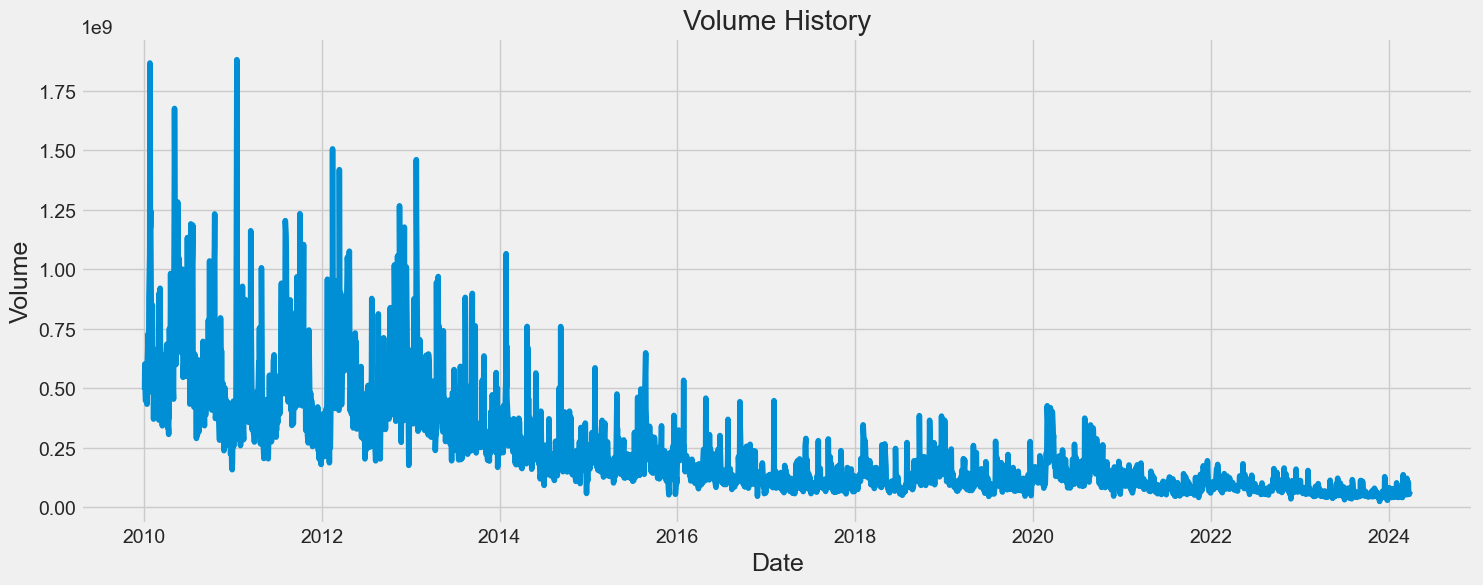

In [7]:
plt.figure(figsize=(16,6))
plt.title('Volume History')
plt.plot(df['Volume'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.show()

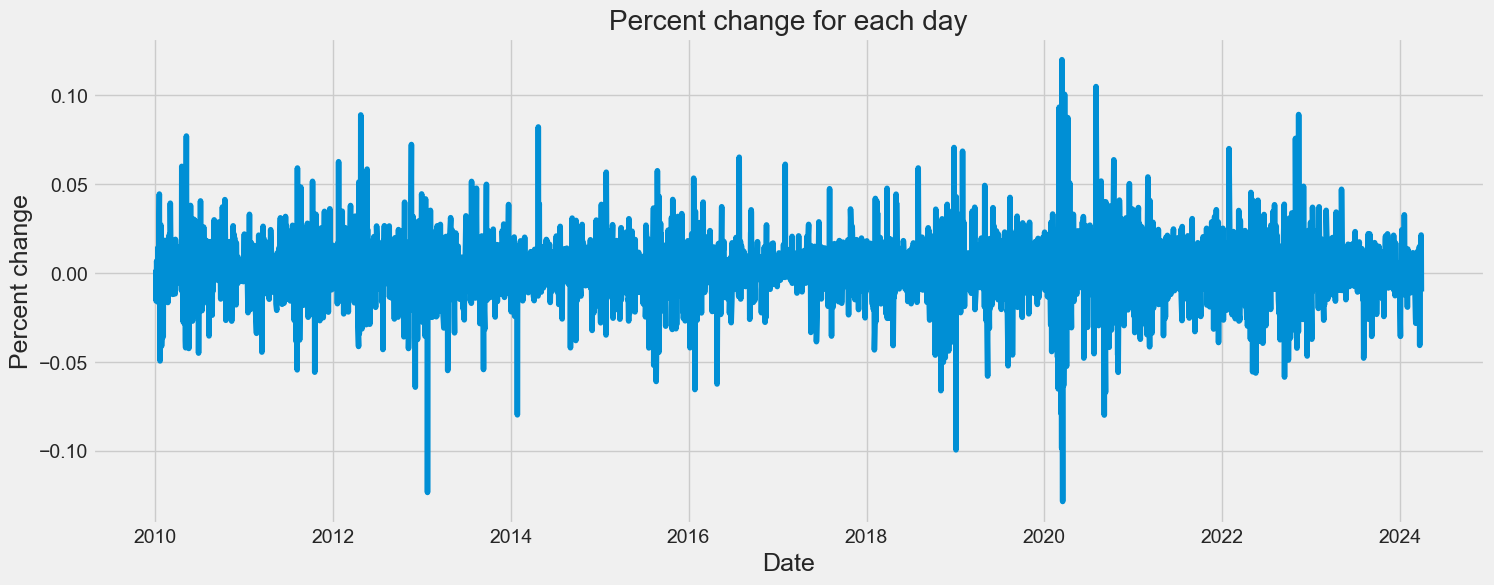

In [8]:
plt.figure(figsize=(16,6))
plt.title('Percent change for each day')
plt.plot(df['Close'].pct_change())
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percent change', fontsize=18)
plt.show()

Text(0, 0.5, 'Counts')

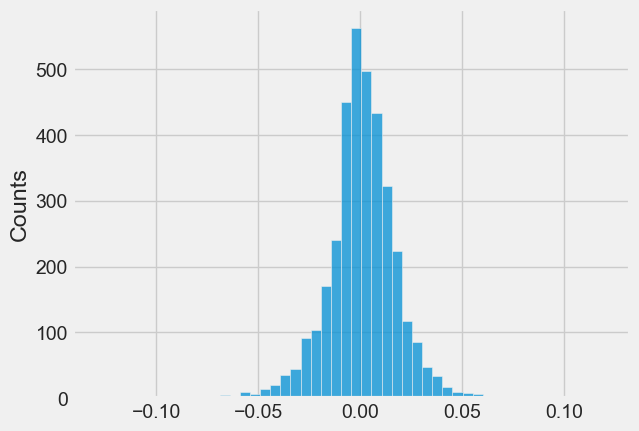

In [9]:
plt.hist(df['Close'].pct_change(), bins=50, alpha=0.75)
plt.ylabel('Counts')

In [45]:
data = df.filter(['Close'])

dataset = data.values
dataset

mask = df.index < '2023-01-01'
training_data_len = len(data.loc[mask])
print(training_data_len)

dataset.shape


3272


(3583, 1)

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00410081],
       [0.00416991],
       [0.00353313],
       ...,
       [0.85150413],
       [0.87032751],
       [0.86075892]])

In [5]:
window_size = 60

train_data = scaled_data[0:training_data_len, :]

x_train = []    
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(3212, 60, 1)

In [6]:
test_data = scaled_data[training_data_len - window_size:, :]

x_test = []
y_test = dataset[training_data_len:, :]


for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [35]:
x_train.shape[1]

60

In [36]:
MLP_model = Sequential()

MLP_model.add(Flatten(input_shape=(x_train.shape[1], 1)))
MLP_model.add(Dense(50, activation='relu'))
MLP_model.add(Dense(50, activation='relu'))
MLP_model.add(Dense(1 , activation='linear'))

MLP_model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Henry\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
history_MLP = MLP_model.fit(x_train, y_train, batch_size=40, epochs=10)

Epoch 1/10


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 0.0039
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 5.5159e-04
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 4.0597e-04
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 3.1027e-04
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 3.4875e-04
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 2.7827e-04
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 3.5328e-04
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 3.6572e-04
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 3.0214e-04
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 3.1193e-04


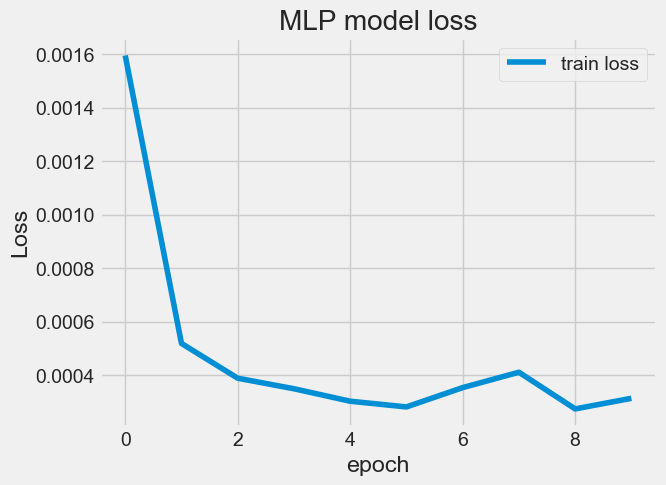

In [43]:
plt.plot(history_MLP.history['loss'], label='train loss')
plt.title('MLP model loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [39]:
MLP_predictions = MLP_model.predict(x_test)
MLP_predictions = scaler.inverse_transform(MLP_predictions)

print("MSE", metrics.mean_squared_error(y_test, MLP_predictions))
print("MSE", metrics.mean_squared_error(y_test, MLP_predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, MLP_predictions)))
print("R2", metrics.explained_variance_score(y_test, MLP_predictions))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(311, 1)
MSE 29.068296729828457
MSE 29.068296729828457
RMSE 5.391502270223806
R2 0.9108909929402229


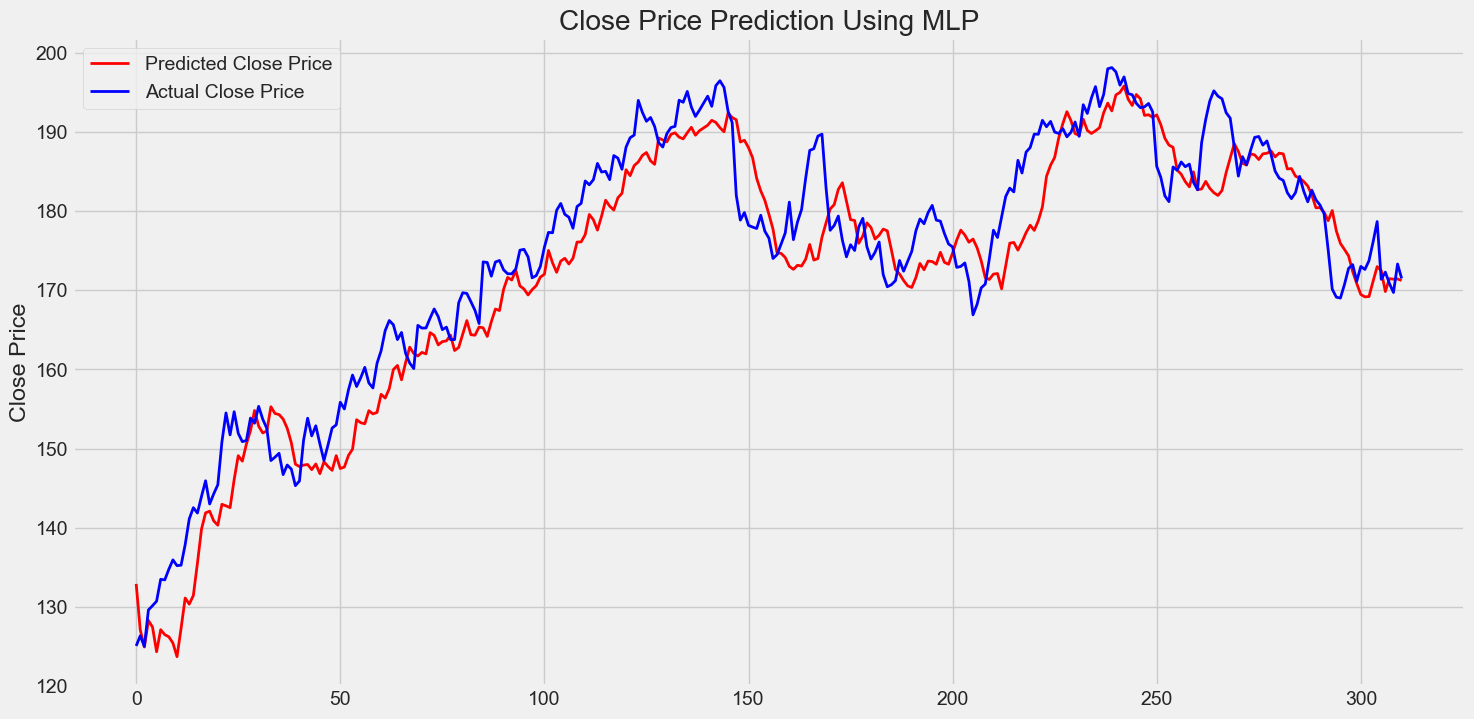

In [40]:
plt.figure(figsize=(16,8))

plt.plot(MLP_predictions, label='Predicted Close Price', linewidth = 2, color='red')
plt.plot(y_test, label='Actual Close Price', linewidth = 2, color='blue')
plt.title('Close Price Prediction Using MLP')
plt.legend(loc = 'best')
plt.ylabel('Close Price')
plt.show()

In [41]:
MLP_model.save('models/MLP_model.keras')

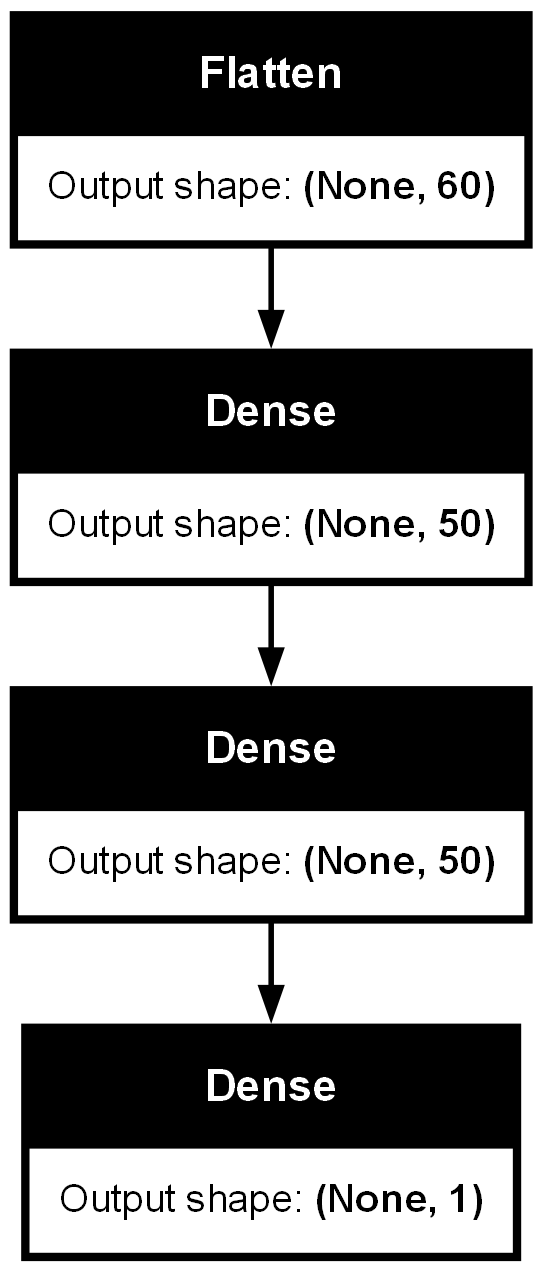

In [44]:
keras.utils.plot_model(MLP_model, to_file='./images/MLP_model.png', show_shapes=True)

In [60]:
RNN_model = Sequential()


RNN_model.add(Input(shape=(x_train.shape[1], 1)))
RNN_model.add(SimpleRNN(50, return_sequences=True))
RNN_model.add(SimpleRNN(50, return_sequences=False))
RNN_model.add(Dense(25))
RNN_model.add(Dense(1))

RNN_model.compile(optimizer='adam', loss='mean_squared_error')


In [65]:
history_RNN = RNN_model.fit(x_train, y_train, batch_size=40, epochs=10)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4309e-04
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7532e-05
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7496e-05
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0202e-05
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7958e-05
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8712e-05
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0037e-05
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9283e-05
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0333e-05
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6605e-05


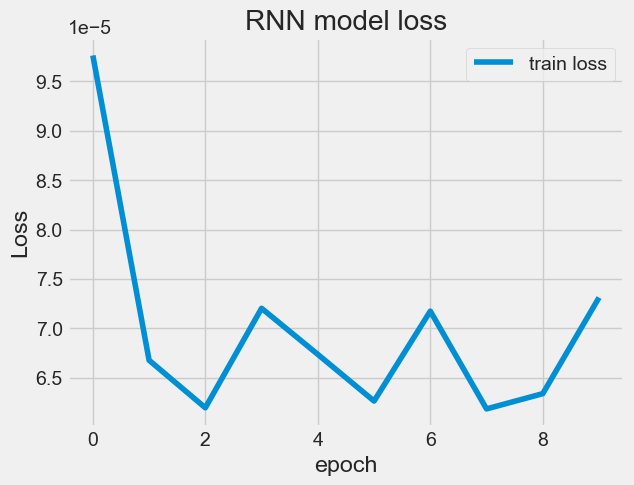

In [81]:
plt.plot(history_RNN.history['loss'], label='train loss')
plt.title('RNN model loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [26]:
RNN_predictions = RNN_model.predict(x_test)

RNN_predictions= scaler.inverse_transform(RNN_predictions)

print("MSE", metrics.mean_squared_error(y_test, RNN_predictions))
print("MSE", metrics.mean_squared_error(y_test, RNN_predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, RNN_predictions)))
print("R2", metrics.explained_variance_score(y_test, RNN_predictions))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
x_test shape (311, 60, 1)
shape (311, 1)
shape (311, 1)
MSE 7.199415377225169
MSE 7.199415377225169
RMSE 2.683172632766138
R2 0.9809872163492853


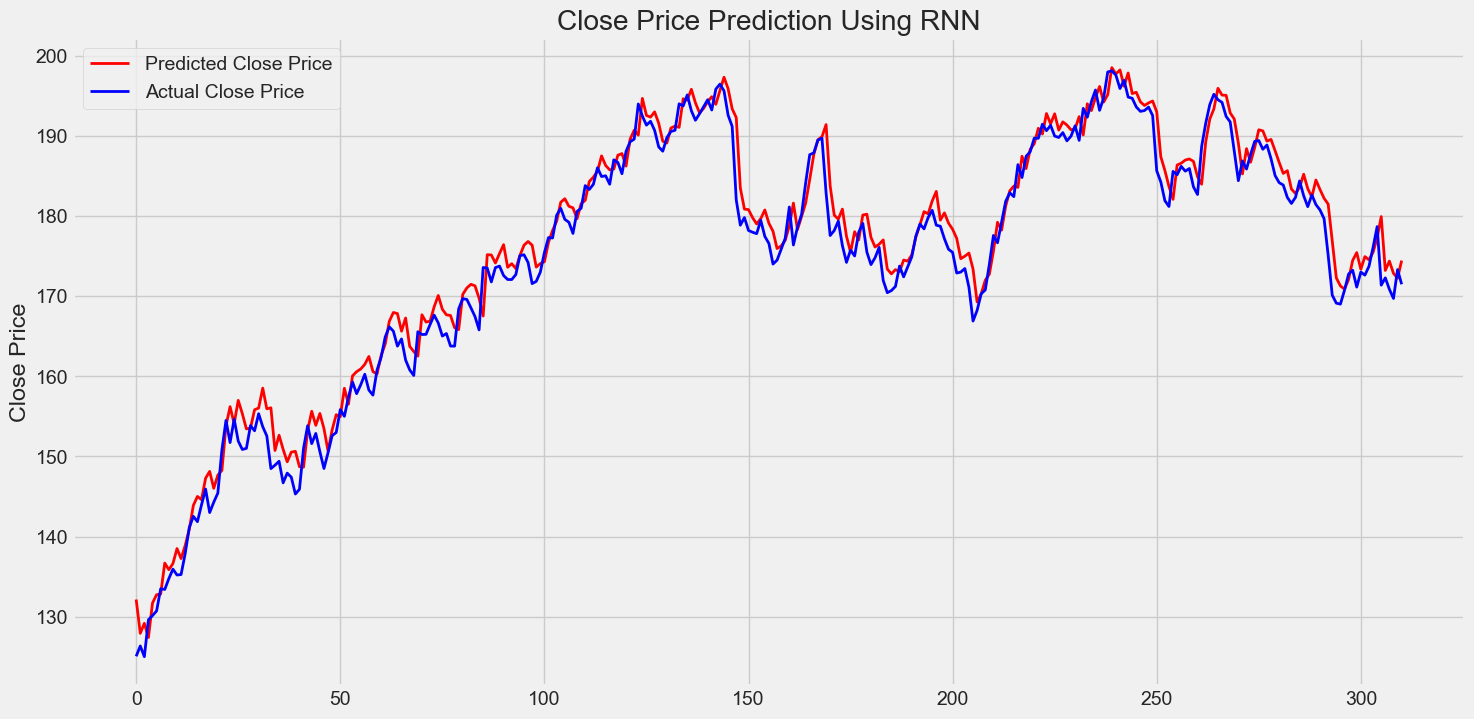

In [67]:
plt.figure(figsize=(16,8))

plt.plot(RNN_predictions, label='Predicted Close Price', linewidth = 2, color='red')
plt.plot(y_test, label='Actual Close Price', linewidth = 2, color='blue')
plt.title('Close Price Prediction Using RNN')
plt.legend(loc = 'best')
plt.ylabel('Close Price')
plt.show()

In [68]:
RNN_model.save('./models/RNN_model.keras')

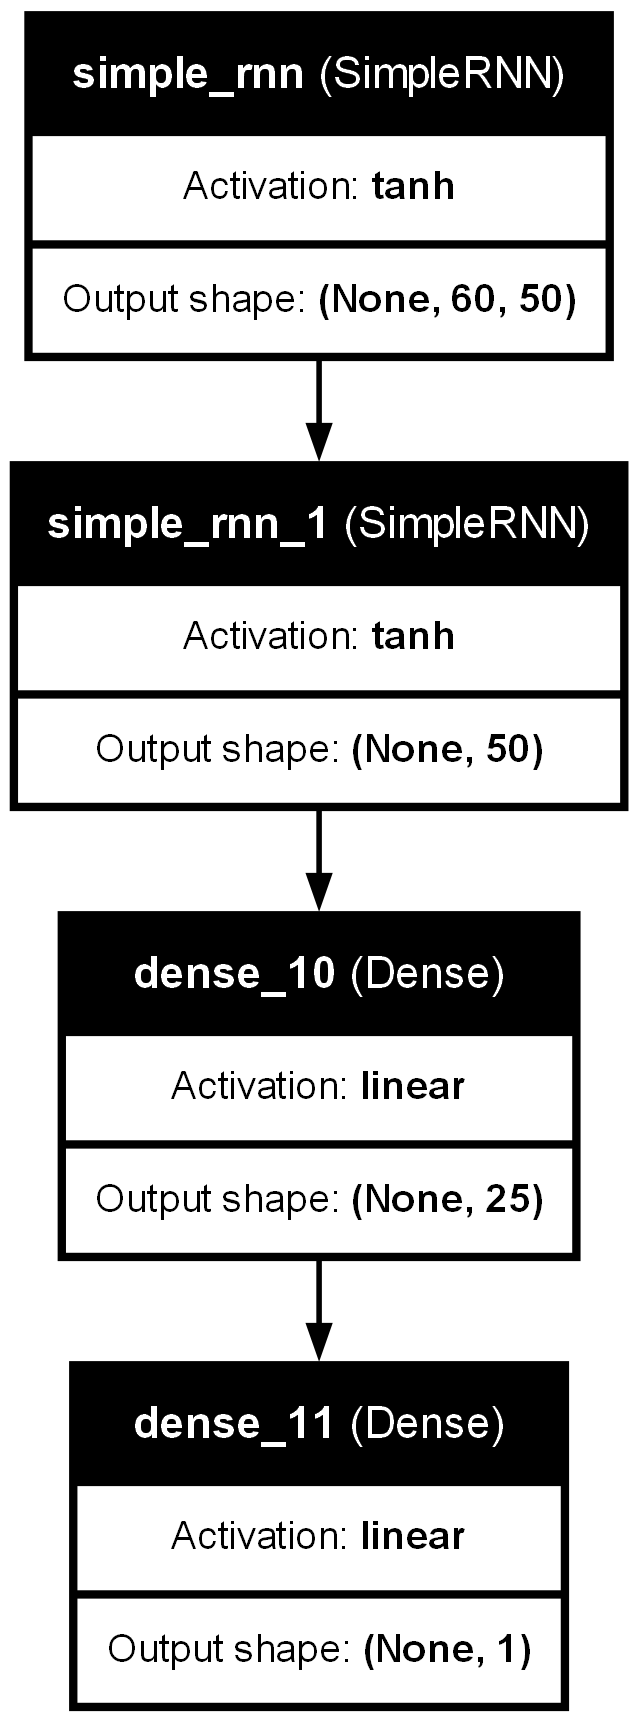

In [22]:
import keras


RNN_model = keras.models.load_model('./models/RNN_model.keras')
keras.utils.plot_model(RNN_model, to_file= './images/RNN_model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)


In [73]:
LSTM_model = Sequential()

LSTM_model.add(Input(shape=(x_train.shape[1], 1)))
LSTM_model.add(LSTM(128, return_sequences=True))
LSTM_model.add(LSTM(64, return_sequences=False))
LSTM_model.add(Dense(25))
LSTM_model.add(Dense(1))

LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

In [74]:
history_LSTM = LSTM_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0038
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 3.2411e-04
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2.3906e-04
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 3.4968e-04
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.9291e-04
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.9410e-04
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.4895e-04
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.6643e-04
Epoch 9/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.0240e-04
Epoch 10/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.6304e-04


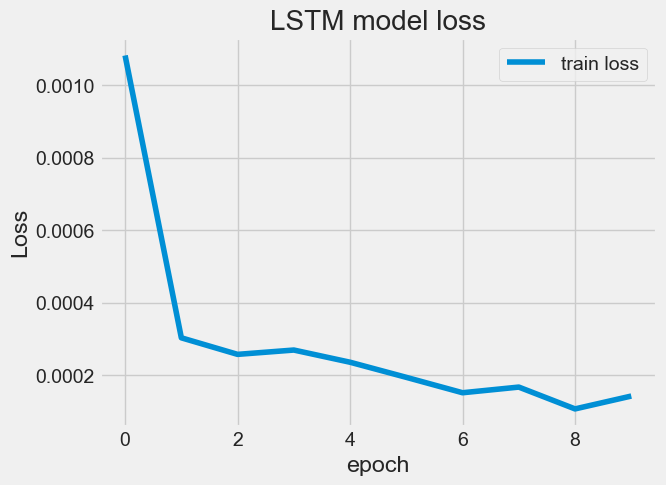

In [80]:
plt.plot(history_LSTM.history['loss'], label='train loss')
plt.title('LSTM model loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [75]:
LSTM_predictions = LSTM_model.predict(x_test)
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)

print("MAE", metrics.mean_absolute_error(y_test, LSTM_predictions))
print("MSE", metrics.mean_squared_error(y_test, LSTM_predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, LSTM_predictions)))    
print("R2", metrics.explained_variance_score(y_test, LSTM_predictions))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
MAE 1.9757030278540118
MSE 6.404415333462569
RMSE 2.530694634574185
R2 0.9758490844620434


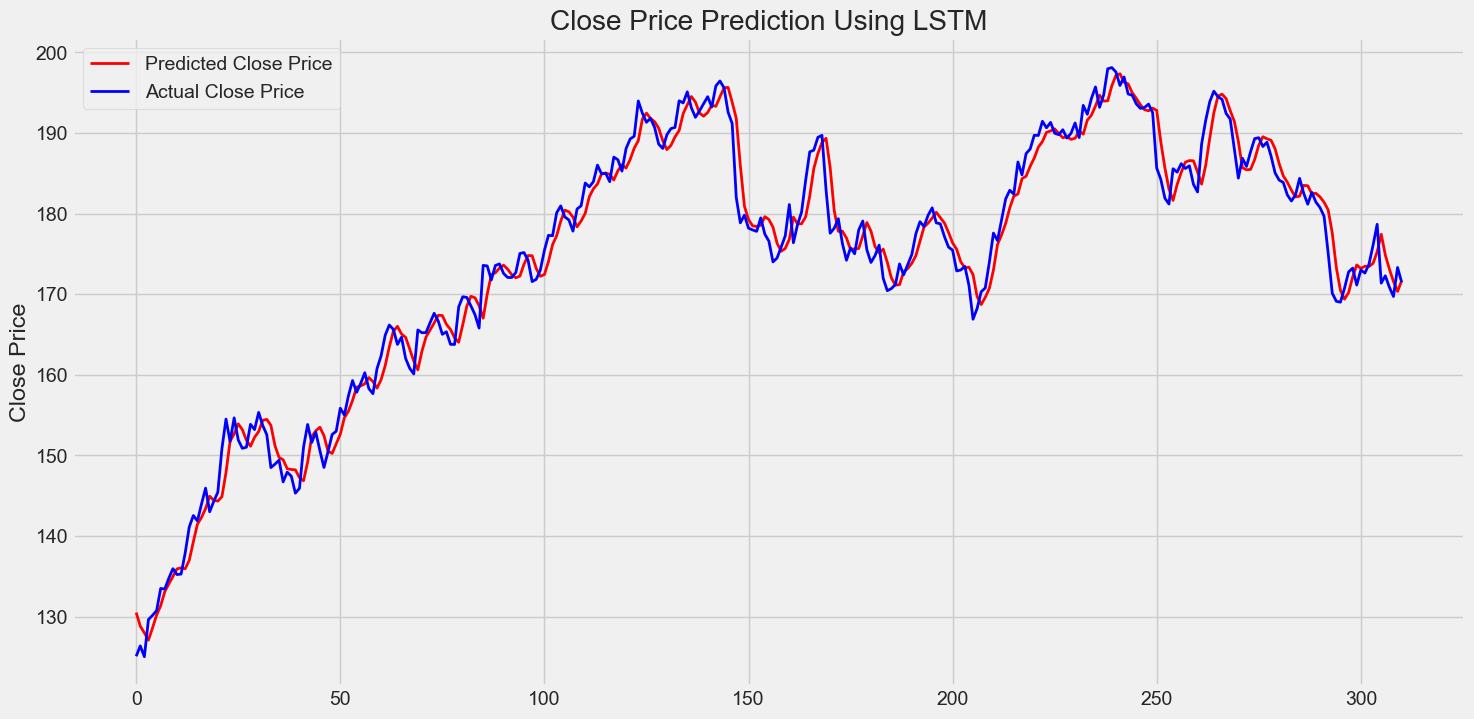

In [76]:
plt.figure(figsize=(16,8))

plt.plot(LSTM_predictions, label='Predicted Close Price', linewidth = 2, color='red')
plt.plot(y_test, label='Actual Close Price', linewidth = 2, color='blue')
plt.title('Close Price Prediction Using LSTM')
plt.legend(loc = 'best')
plt.ylabel('Close Price')
plt.show()

In [77]:
LSTM_model.save('./models/LSTM_model.keras')

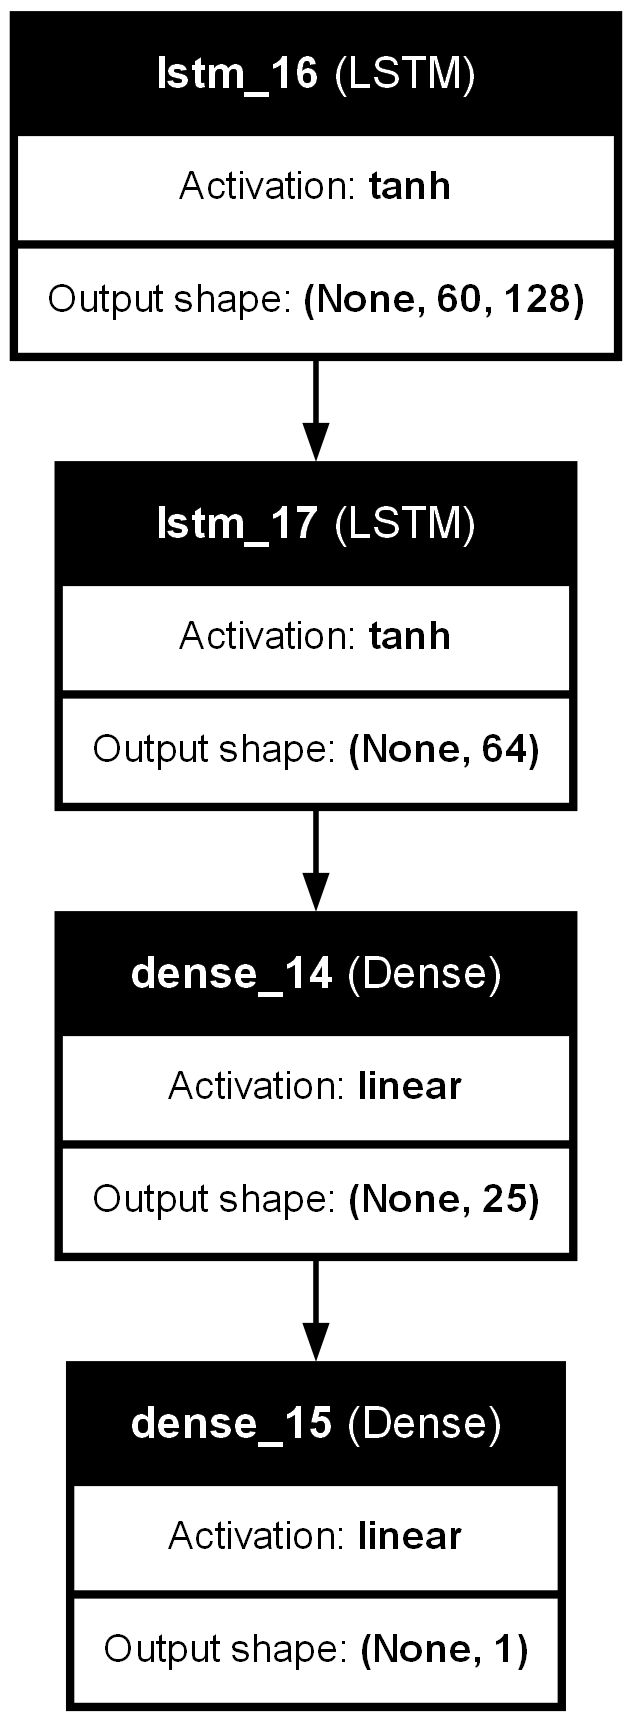

In [8]:
LSTM_model = keras.models.load_model('./models/LSTM_model.keras')

keras.utils.plot_model(LSTM_model, to_file= './images/LSTM_model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [44]:
import tensorflow as tf
from keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from keras.layers import MaxPooling1D, Flatten

model = Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(Input(shape=(x_train.shape[1], window_size, 1)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', )))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])


In [15]:
x_train.shape

(3212, 60, 1)

In [45]:
train_X = x_train.reshape((x_train.shape[0], 1, window_size, 1))
test_X = x_test.reshape((x_test.shape[0], 1, window_size, 1))

Conv_LSTM_history = model.fit(train_X, y_train, validation_data=(test_X, y_test), batch_size=50, epochs=15)

Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0610 - mae: 0.1480 - mse: 0.0610 - val_loss: 30275.2051 - val_mae: 173.4872 - val_mse: 30359.8066
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0226 - mse: 0.0015 - val_loss: 30305.1055 - val_mae: 173.5670 - val_mse: 30388.4336
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0211 - mse: 0.0012 - val_loss: 30310.7773 - val_mae: 173.5807 - val_mse: 30393.5371
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4073e-04 - mae: 0.0181 - mse: 9.4104e-04 - val_loss: 30295.8301 - val_mae: 173.5385 - val_mse: 30378.7070
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7734e-04 - mae: 0.0188 - mse: 8.7762e-04 - val_loss: 30293.3926 - val_mae: 173.5313 - val_mse: 30376.1387
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8768e-04 - mae: 0.0187 - mse: 9.8717e-04 - val_loss: 30300.1035 - val_mae: 173.5496 - val_mse: 30382.5430
Epoch 7/15
65/65 ━━━━━━━━━━

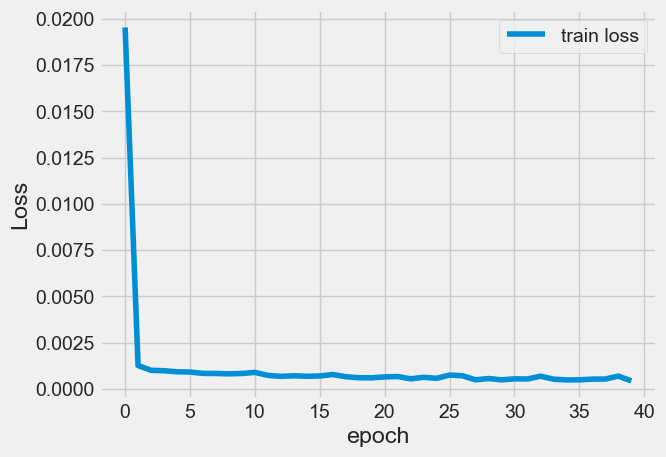

In [40]:
plt.plot(Conv_LSTM_history.history['loss'], label='train loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [46]:
conv_LSTM_predictions = model.predict(test_X)
conv_LSTM_predictions = scaler.inverse_transform(conv_LSTM_predictions)

print("MAE", metrics.mean_absolute_error(y_test, conv_LSTM_predictions))
print("MSE", metrics.mean_squared_error(y_test, conv_LSTM_predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, conv_LSTM_predictions)))
print("R2", metrics.explained_variance_score(y_test, conv_LSTM_predictions))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
MAE 7.616087787787631
MSE 80.40525708847171
RMSE 8.966897852015027
R2 0.795413868115478


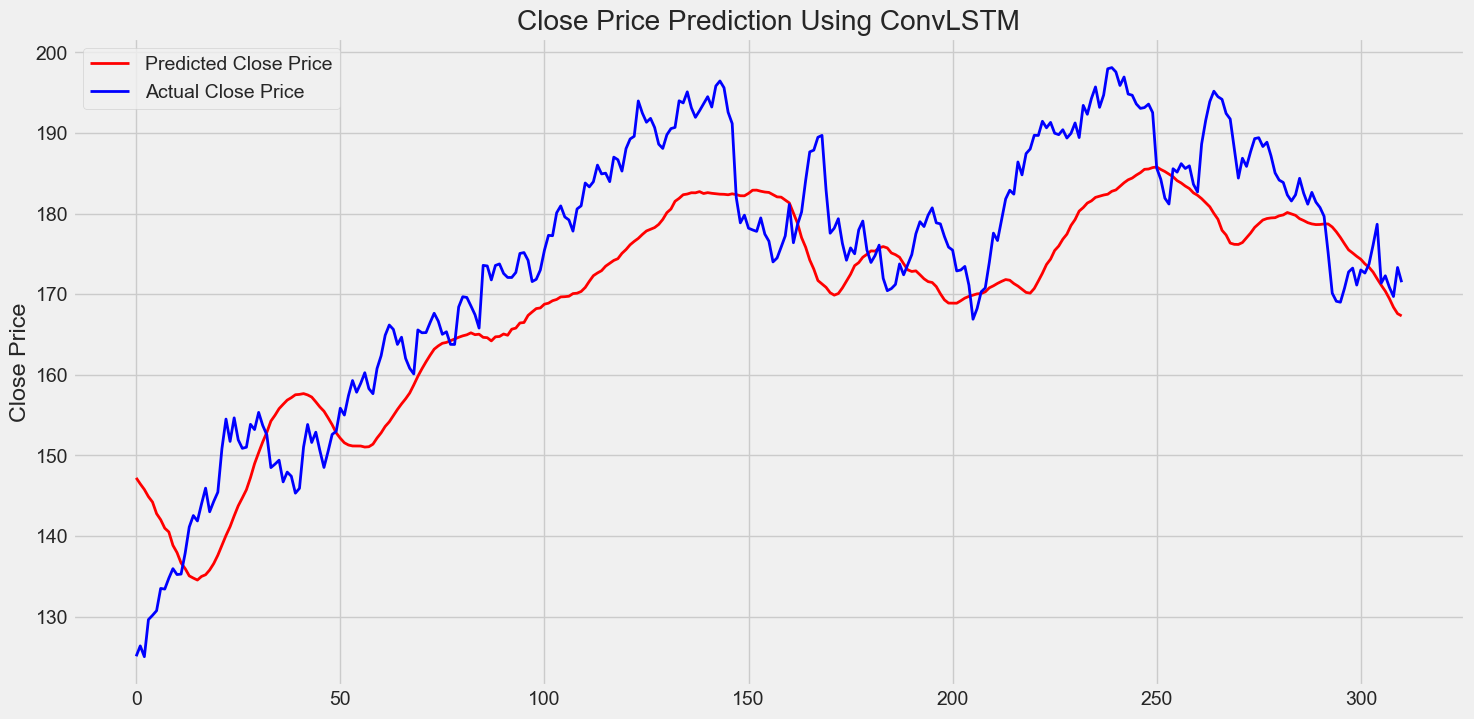

In [48]:
plt.figure(figsize=(16,8))

plt.plot(conv_LSTM_predictions, label='Predicted Close Price', linewidth = 2, color='red')
plt.plot(y_test, label='Actual Close Price', linewidth = 2, color='blue')
plt.title('Close Price Prediction Using ConvLSTM')
plt.legend(loc = 'best')
plt.ylabel('Close Price')
plt.show()

In [78]:
model.save('./models/ConvLSTM_model.keras')

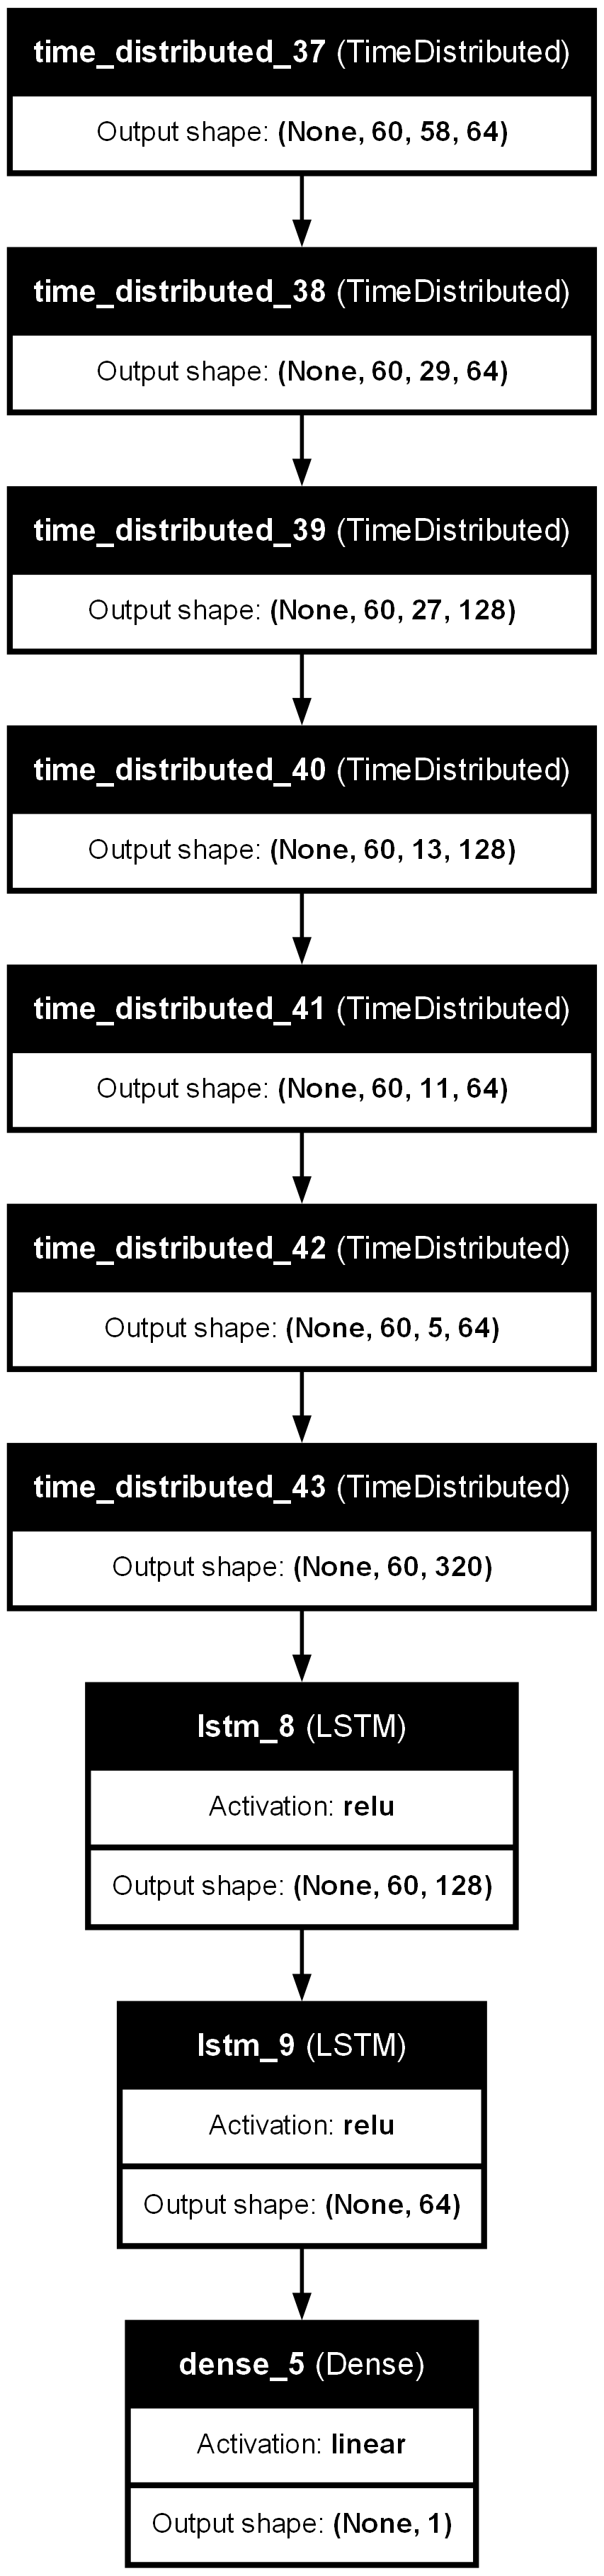

In [9]:
model = keras.models.load_model('./models/ConvLSTM_model.keras')

keras.utils.plot_model(model, to_file= './images/ConvLSTM_model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)